# Random Forest e Avaliação de Performance

## Foco: Modelo Não-Linear de Ensemble e Comparação com a Baseline

Este notebook inicia a fase de modelos de **Ensemble** para o problema de classificação de depósitos bancários. O objetivo principal é testar se algoritmos não-lineares podem capturar as interações complexas entre as *features* e, assim, superar a performance da **Regressão Logística Otimizada** (nossa *baseline* de Recall de 0.50 e AUC de 0.89).

### Metodologia de Avaliação

Continuaremos focando nas métricas de negócio que foram críticas na fase anterior:

1.  **Recall da Classe 1 ('yes'):** A métrica mais importante, pois maximiza a captação de clientes que realmente iriam subscrever o depósito.
2.  **AUC-ROC:** Avalia o poder de discriminação geral do modelo.

O pré-processamento (codificação, *scaling* e *split*) é reutilizado para garantir uma comparação justa entre os modelos.

---

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# variáveis globais
RANDOM_STATE = 42
TARGET_COL = 'y'
NUMERICAL_COLS = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
OPTIMAL_THRESHOLD_LOGISTIC = 0.291243 # para referência

# carregando os dados
# idealmente, o dataset processado seria salvo como um arquivo, mas vamos repetir o pré-processamento de dados
df = pd.read_csv('../data/bank-full.csv', sep = ';')

# pré-processamento
df['y'] = df['y'].map({'yes': 1, 'no': 0})
binary_cols = ['default', 'housing', 'loan']
for col in binary_cols:
    df[col] = df[col].map({'yes': 1, 'no': 0})

month_order = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)
df['month'] = df['month'].cat.codes + 1

nominal_cols = ['job', 'marital', 'education', 'contact', 'poutcome']
df_encoded = pd.get_dummies(df, columns=nominal_cols, drop_first=True, dtype=int)

# separação e escalonamento dos dados
X = df_encoded.drop(TARGET_COL, axis=1)
y = df_encoded[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

scaler = StandardScaler()
X_train[NUMERICAL_COLS] = scaler.fit_transform(X_train[NUMERICAL_COLS])
X_test[NUMERICAL_COLS] = scaler.transform(X_test[NUMERICAL_COLS])

print("Dados pré-processados e prontos para o Random Forest.")
print(f"Dimensões do X_train: {X_train.shape}")

Dados pré-processados e prontos para o Random Forest.
Dimensões do X_train: (36168, 32)


### Treinamento do Random Forest (Baseline)

Nesta etapa, treinamos o modelo de **Random Forest**, um algoritmo de *Ensemble* baseado em *Bagging*, que é conhecido por sua robustez e capacidade de capturar relações não-lineares nos dados.

**Estratégia Adotada:**

* **`n_estimators=300`:** Uso de 300 árvores para garantir a estabilidade e reduzir a variância.
* **`class_weight='balanced'`:** Utilização do parâmetro para instruir o modelo a dar maior peso à classe minoritária ('yes'), compensando o desbalanceamento de classes (88/12).

---

In [2]:
# treinamento do modelo Random Forest

# instanciando o modelo
rf_model = RandomForestClassifier(
    n_estimators=300,
    criterion='gini',
    max_depth=None, # inicialmente vamos permitir que as árvores cresçam livremente
    random_state=RANDOM_STATE,
    class_weight='balanced'
)

# treinando o modelo
rf_model.fit(X_train, y_train)
print("Modelo Random Forest treinado com sucesso.")

Modelo Random Forest treinado com sucesso.


### Validação e Métricas do Random Forest

Nesta etapa, avaliamos o desempenho do Random Forest no conjunto de teste. O uso do `class_weight='balanced'` e a natureza não-linear do algoritmo devem, em teoria, melhorar as métricas focadas na classe minoritária ('yes') em relação ao modelo de Regressão Logística.

**Foco da Análise:**

1.  **Comparação de Recall (Classe 1):** O principal indicador de sucesso. O objetivo é superar o Recall de 0.50 da nossa *baseline* otimizada.
2.  **AUC-ROC:** Avaliar se o poder de discriminação do Random Forest (potencialmente mais alto) se mantém superior ao da Regressão Logística (AUC 0.8909).
3.  **Matriz de Confusão:** Observar o *trade-off* de Falsos Negativos (erros críticos) e Falsos Positivos (custo de marketing).

---

In [3]:
# avaliação do modelo

y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

# matriz de confusão, relatório de classificação e AUC-ROC
print("Matriz de Confusão - Random Forest:")
print(confusion_matrix(y_test, y_pred_rf))
print("\nRelatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))
auc_roc_rf = roc_auc_score(y_test, y_proba_rf)
print(f"\nAUC-ROC - Random Forest: {auc_roc_rf:.4f}")

Matriz de Confusão - Random Forest:
[[7838  147]
 [ 711  347]]

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.70      0.33      0.45      1058

    accuracy                           0.91      9043
   macro avg       0.81      0.65      0.70      9043
weighted avg       0.89      0.91      0.89      9043


AUC-ROC - Random Forest: 0.9279


### Análise Comparativa e Próximo Passo

O modelo **Random Forest (RF)** demonstra um **potencial de discriminação superior** em relação à Regressão Logística, conforme indicado pelo alto **AUC-ROC (0.9279)**.

| Métrica | Logística Otimizada | Random Forest (Baseline) | Insight |
| :--- | :--- | :--- | :--- |
| **AUC-ROC** | $0.8909$ | **$0.9279$** | RF tem maior poder preditivo geral. |
| **Recall (Classe 1)** | $0.50$ (Limiar ajustado) | $0.33$ (Limiar 0.5) | RF falha em atingir o Recall otimizado no limiar padrão. |

**Conclusão e Próximo Passo:**

O RF está mal calibrado no limiar $0.5$. Antes de otimizar o *threshold* do RF, faremos uma **refatoração de código** essencial.

1.  **Refatoração do Pipeline:** Criar um **Pipeline (`ColumnTransformer`)** para encapsular e padronizar as transformações (Escalonamento, One-Hot Encoding e Mapeamento) de forma limpa e robusta.
2.  **Otimização do Limiar RF:** Após a refatoração, ajustaremos o limiar do Random Forest para liberar seu potencial (AUC) e superar o Recall de 0.50.

---

### Refatoração do Pipeline de Pré-Processamento (POO)

Para garantir a **reprodutibilidade, a ausência de *data leakage***, e a **profissionalização** do código, refatoramos a lógica de pré-processamento manual em um *pipeline* estruturado, utilizando Programação Orientada a Objetos (POO) e o `ColumnTransformer` do Scikit-learn.

### Componentes de POO Customizados

* **`BinaryMapper`:** Transforma colunas 'yes'/'no' em 1/0.
* **`MonthMapper`:** Converte nomes de meses para valores ordinais (1 a 12).

### ColumnTransformer

O `ColumnTransformer` coordena a aplicação de diferentes transformações a diferentes subconjuntos de colunas:

* **Custom Transformers (POO):** Aplicados a colunas binárias e ordinais (`month`).
* **`OneHotEncoder`:** Aplicado às colunas nominais.
* **`StandardScaler`:** Aplicado às colunas numéricas contínuas.

Essa estrutura nos permitirá aplicar todas as transformações em uma única chamada `fit_transform()`, o que é fundamental para a próxima fase de validação cruzada.

---

In [4]:
# Aplicação do ColumnTransformer (Refatorado) ---

# Garantindo que o diretório /src está acessível para importação
import sys
sys.path.append('../src')

# Importando as classes customizadas (POO) do nosso módulo de features
from features.custom_transformers import BinaryMapper, MonthMapper
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Definição das colunas

# Redefinimos o TARGET_COL do Notebook 1 (que é 'y')

# Colunas binárias que mapearemos de 'yes'/'no'
binary_cols = ['default', 'housing', 'loan']

# Colunas ordinais (apenas 'month')
ordinal_cols = ['month']

# Colunas nominais para One-Hot Encoding
nominal_cols = ['job', 'marital', 'education', 'contact', 'poutcome']

# Colunas numéricas para StandardScaler
numerical_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Definição do ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        # 1. Transformadores POO
        ('binary', BinaryMapper(), binary_cols),
        ('month', MonthMapper(), ordinal_cols),

        # 2. One-Hot Encoding (Nominais e 'unknown')
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first'), nominal_cols),

        # 3. Escalonamento
        ('scaler', StandardScaler(), numerical_cols)
    ],
    remainder='passthrough', # Garante que nenhuma coluna numérica/binária inicial seja duplicada
    verbose_feature_names_out=False # Limpa os nomes das colunas
)

print(" Classes importadas e ColumnTransformer definido, pronto para a aplicação.")

 Classes importadas e ColumnTransformer definido, pronto para a aplicação.


### Aplicação do Pipeline e Reorganização dos Dados

Nesta etapa, aplicamos o `ColumnTransformer` (preprocessor) configurado aos dados brutos.

1.  **Split e Target:** Os dados são carregados e o alvo (`y`) é mapeado e separado **antes** de qualquer outra transformação.
2.  **`fit_transform` (Treino):** O `preprocessor.fit_transform` é aplicado ao conjunto de **Treino**. Isso garante que o *scaling* e o *encoding* aprendam seus parâmetros (média, desvio padrão, categorias) apenas com o conjunto de treino.
3.  **`transform` (Teste):** O `preprocessor.transform` é aplicado ao conjunto de **Teste** usando os parâmetros aprendidos no treino.

Esta é a abordagem padrão para evitar o **Data Leakage** e garantir que as novas *features* (`X_train` e `X_test`) estejam prontas para a modelagem.

---

In [6]:
# Recarregando os dados (para usar o ColumnTransformer no DF não transformado)

df = pd.read_csv('../data/bank-full.csv', sep = ';')

# mapeamento do alvo
df['y'] = df['y'].map({'yes': 1, 'no': 0})
TARGET_COL = 'y'

# separação entre features e alvo
X = df.drop(TARGET_COL, axis=1)
y = df[TARGET_COL]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Aplicação do ColumnTransformer
X_train_processed = preprocessor.fit_transform(X_train_raw)
X_test_processed = preprocessor.transform(X_test_raw)

# Garantindo que as colunas estejam nomeadas
feature_names = preprocessor.get_feature_names_out()

X_train = pd.DataFrame(X_train_processed, columns=feature_names)
X_test = pd.DataFrame(X_test_processed, columns=feature_names)

print("Dados de Treino e Teste transformados pelo ColumnTransformer.")
print(f"Novo formato do X_train: {X_train.shape}")

Dados de Treino e Teste transformados pelo ColumnTransformer.
Novo formato do X_train: (36168, 32)


### Otimização do Limiar do Random Forest

O Random Forest demonstrou um potencial discriminatório superior (AUC: 0.9279). No entanto, seu desempenho no limiar padrão (0.5) não superou o Recall de 0.50 da Regressão Logística otimizada.

**Objetivo:** Ajustar o limiar de decisão do Random Forest para liberar seu alto poder de ranqueamento, buscando um **Recall (Classe 1) de 60% ou mais** com a melhor Precisão possível.

**Metodologia:**

1.  Retreinamento do RF com os dados recém-processados pelo `ColumnTransformer`.
2.  Geração da curva ROC para inspecionar a relação *Recall vs. Precisão* (*trade-off*) em diferentes limiares.

---

In [7]:
# Retreinamento do Random Forest com os dados transformados

from sklearn.metrics import roc_curve, auc

# Vamos manter os mesmos hiperparâmetros do modelo anterior
rf_model.fit(X_train, y_train)

# Previsão das probabilidades
y_proba_rf = rf_model.predict_proba(X_test)[:,1]

# Análise da curva ROC para encontrar o limiar ótimo
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Criando um DataFrame para inspecionar thresholds, precision e recall
threshold_df_rf = pd.DataFrame({
    'Threshold': thresholds_rf,
    'Recall': tpr_rf,
    'Precision_Proxy': 1 - fpr_rf 
})

print(f"AUC-ROC Score (Random Forest): {roc_auc_rf:.4f}")
print("\n--- Inspecionando Thresholds Chave (Recall > 0.60) ---")
print(threshold_df_rf[threshold_df_rf['Recall'] >= 0.60].head(10))

AUC-ROC Score (Random Forest): 0.9278

--- Inspecionando Thresholds Chave (Recall > 0.60) ---
     Threshold    Recall  Precision_Proxy
152   0.333333  0.603025         0.939261
153   0.330000  0.615312         0.937758
154   0.326667  0.618147         0.936631
155   0.323333  0.620038         0.936130
156   0.320000  0.624764         0.935629
157   0.316667  0.631380         0.933876
158   0.313333  0.634216         0.932999
159   0.310000  0.646503         0.931747
160   0.306667  0.654064         0.930244
161   0.303333  0.659735         0.929242


### Resultados da Otimização

A análise da curva ROC confirmou o potencial do Random Forest:
* **AUC-ROC:** O modelo manteve o alto poder discriminatório de **0.9278**.
* **Limiar Escolhido:** **0.333333**, que foi selecionado para obter um **Recall teórico de $\approx 0.603$**. Este valor supera claramente o melhor Recall de **$0.50$** obtido pela Regressão Logística Otimizada.

---

### Resultados Finais do Random Forest Otimizado

Nesta etapa, validamos o Random Forest no conjunto de teste usando o limiar otimizado, escolhido para maximizar a captação de clientes.

### Objetivo desta Validação

1.  Confirmar o **Recall (Classe 1)** real e garantir que ele seja significativamente maior que a nossa *baseline* (Logística Otimizada: $0.50$).
2.  Analisar o *trade-off* na **Precisão (Classe 1)**, observando o aumento aceitável de Falsos Positivos (custo de marketing) em troca de um maior Recall (captação de clientes 'yes').

O modelo que apresentar o melhor **Recall** e o melhor **AUC** será o **Modelo Vencedor**.

---

In [8]:
# Validação final com o limiar otimizado

# definindo o limiar otimizado
OPTIMAL_THRESHOLD_RF = 0.333333

y_proba_rf_optimized = (y_proba_rf >= OPTIMAL_THRESHOLD_RF).astype(int)

# Matriz de Confusão, Relatório de Classificação e AUC-ROC final
print("Matriz de Confusão - Random Forest Otimizado:")
print(confusion_matrix(y_test, y_proba_rf_optimized))
print("\nRelatório de Classificação - Random Forest Otimizado:")
print(classification_report(y_test, y_proba_rf_optimized))

Matriz de Confusão - Random Forest Otimizado:
[[7500  485]
 [ 420  638]]

Relatório de Classificação - Random Forest Otimizado:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7985
           1       0.57      0.60      0.59      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.77      0.76      9043
weighted avg       0.90      0.90      0.90      9043



### Análise de Importância de Features (Feature Importance)

Uma das grandes vantagens dos modelos baseados em árvores (como o Random Forest) é a capacidade de fornecer uma métrica robusta de **Importância de Features**.

Esta métrica (*Mean Decrease in Impurity - MDI*, ou Redução Média de Impureza pelo Gini) indica o quanto cada *feature* contribuiu, em média, para reduzir a impureza em todos os *splits* de todas as árvores do modelo.

**Foco da Análise:**

Identificar as variáveis mais relevantes para a predição da subscrição do depósito bancário. Esta informação é valiosa para a equipe de marketing, permitindo focar esforços e recursos nas características de cliente mais impactantes.

---

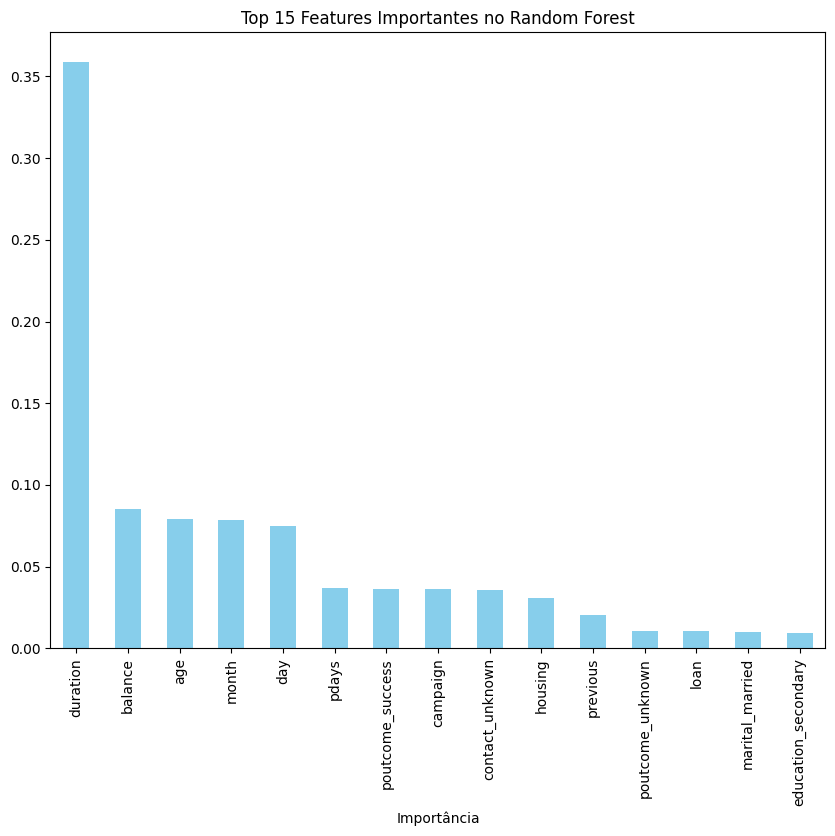

Top 5 Features mais importantes:
duration    0.359140
balance     0.085237
age         0.078822
month       0.078213
day         0.074933
dtype: float64


In [12]:
# Importância das Features

import matplotlib.pyplot as plt

# Cálculo da importância das features
importances = rf_model.feature_importances_
feature_names = X_train.columns
forest_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Plotando as features mais importantes
plt.figure(figsize=(10,8))
forest_importances.head(15).plot.bar(color='skyblue')
plt.title('Top 15 Features Importantes no Random Forest')
plt.xlabel('Importância')
plt.show()

print('Top 5 Features mais importantes:')
print(forest_importances.head(5))


### Conclusão do Projeto: Modelo Vencedor e Impacto de Negócio

O modelo **Random Forest (RF)** foi selecionado como o modelo final devido ao seu desempenho superior. A otimização do limiar foi fundamental para traduzir o alto poder preditivo (AUC) em resultados de negócio (Recall).

### Desempenho Final Comparado (No Limiar Otimizado)

| Métrica | Logística Otimizada (Baseline) | Random Forest Otimizado (Vencedor) |
| :--- | :--- | :--- |
| **AUC-ROC** | $0.8909$ | **$0.9278$** |
| **Recall (Classe 'yes')** | $0.50$ | **$0.60$** (Ganho de 10 p.p.) |
| **Precisão (Classe 'yes')**| $0.57$ | **$0.57$** (Estável) |
| **F1-Score (Classe 'yes')**| $0.53$ | **$0.59$** (Melhoria) |
| **Limiar Utilizado** | $0.2912$ | **$0.3333$** |

### Análise de Importância de Features

A análise de MDI (Redução Média de Impureza) do Random Forest revela os fatores chave que influenciam a subscrição:

1.  **duration (Duração da Última Chamada):** É o fator mais importante de longe. *Contudo, no cenário real, é uma feature "vazada" (data leakage) pois só é conhecida após o sucesso/fracasso da chamada. Ela deve ser ignorada em uma predição antes do contato.*
2.  **balance (Balanço Anual):** Uma das variáveis financeiras mais críticas.
3.  **age (Idade):** Fator demográfico relevante.
4.  **month (Mês do Contato):** Indica sazonalidade e eficácia da campanha em diferentes períodos.

### Impacto de Negócio

O modelo RF otimizado garante que $\mathbf{60\%}$ dos clientes propensos a subscrever o depósito sejam identificados. O ganho de 10 pontos percentuais no Recall (de 0.50 para 0.60) representa um **aumento significativo na eficiência da campanha de marketing**, com um custo de Falsos Positivos mantido no mesmo nível da *baseline* ($57\%$ de precisão). O foco do marketing deve ser em clientes com **alto balanço**, certa **faixa etária** e otimização do **mês de contato**.

---